We are going to be working with the Adult Data Set that is availabvle in http://archive.ics.uci.edu/ml/datasets/Adult.  This data set was created to predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.

This requires a rather large Neural Network, and here we will demonstrate how you can start training your model, save the model and continue training the model sometime later.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import feature_column
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import confusion_matrix

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df=pd.read_csv("adult.csv")

In [4]:
df.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

This is not a format that is suitable for training a neural network. We will transform it.

Change all the ?  to nan

In [5]:
df['income'] = np.where(df['income']=="<=50K", 0, 1)

In [6]:
df["workclass"].unique()

array(['?', 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [7]:
df["education"].unique()

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

In [8]:
df["marital.status"].unique()

array(['Widowed', 'Divorced', 'Separated', 'Never-married',
       'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [9]:
df["occupation"].unique()

array(['?', 'Exec-managerial', 'Machine-op-inspct', 'Prof-specialty',
       'Other-service', 'Adm-clerical', 'Craft-repair',
       'Transport-moving', 'Handlers-cleaners', 'Sales',
       'Farming-fishing', 'Tech-support', 'Protective-serv',
       'Armed-Forces', 'Priv-house-serv'], dtype=object)

In [10]:
df["race"].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [11]:
df["relationship"].unique()

array(['Not-in-family', 'Unmarried', 'Own-child', 'Other-relative',
       'Husband', 'Wife'], dtype=object)

In [12]:
df["sex"].unique()

array(['Female', 'Male'], dtype=object)

In [13]:
df["native.country"].unique()

array(['United-States', '?', 'Mexico', 'Greece', 'Vietnam', 'China',
       'Taiwan', 'India', 'Philippines', 'Trinadad&Tobago', 'Canada',
       'South', 'Holand-Netherlands', 'Puerto-Rico', 'Poland', 'Iran',
       'England', 'Germany', 'Italy', 'Japan', 'Hong', 'Honduras', 'Cuba',
       'Ireland', 'Cambodia', 'Peru', 'Nicaragua', 'Dominican-Republic',
       'Haiti', 'El-Salvador', 'Hungary', 'Columbia', 'Guatemala',
       'Jamaica', 'Ecuador', 'France', 'Yugoslavia', 'Scotland',
       'Portugal', 'Laos', 'Thailand', 'Outlying-US(Guam-USVI-etc)'],
      dtype=object)

Transform all the text data into numbers. 

In [14]:
df = df.drop(columns=['fnlwgt'])

In [15]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

20838 train examples
5210 validation examples
6513 test examples


In [16]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('income')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [17]:
batch_size = 64
train_ds = df_to_dataset(df, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [18]:
feature_columns = []


In [19]:
for header in ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
  feature_columns.append(feature_column.numeric_column(header))

In [20]:
indicator_column_names = ['workclass', 'education', 'marital.status', 'occupation', 'race',
                          'relationship', 'sex', 'native.country']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

In [21]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [22]:
batch_size = 32
train_ds = df_to_dataset(df, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

Our model wil be large, and it will take a long time to train.  

In [23]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

result = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.


C:\Users\Ivan Krsul\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


Consider rewriting this model with the Functional API.
1010/1018 [============================>.] - ETA: 0s - loss: 0.8730 - tp: 3563.0000 - fp: 2322.0000 - tn: 22228.0000 - fn: 4207.0000 - accuracy: 0.7980 - precision: 0.6054 - recall: 0.4586WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'workclass': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=string>, 'education': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'education.num': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=int64>, 'marital.status': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'occupation': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'relationship': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=string>, 'race': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'sex': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) d

In [24]:
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

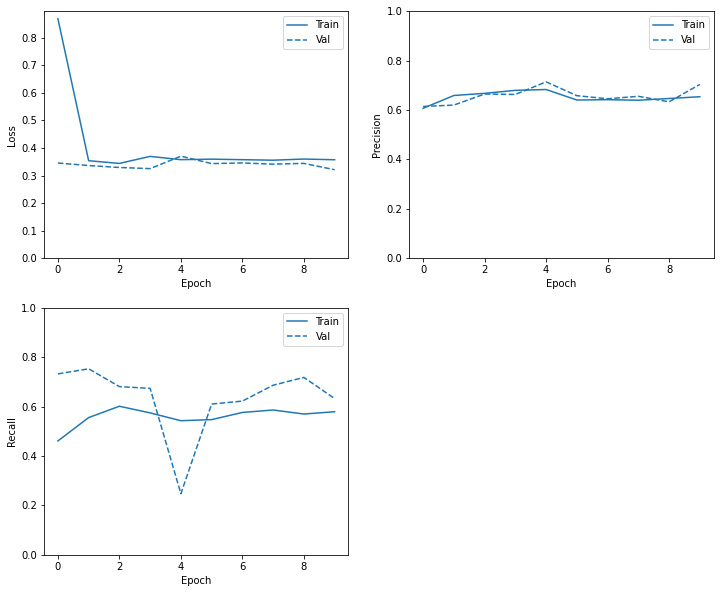

In [25]:
plot_metrics(result)

In [26]:
predictions = model.predict(test_ds)

Consider rewriting this model with the Functional API.


In [27]:
def plotConfusion(test_labels, predictions_baseline, p):
    cm = confusion_matrix(test_labels, predictions_baseline > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(0.5))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    truePositives = cm[1][1]
    trueNegatives = cm[0][0]
    falsePositives = cm[0][1]
    falseNegatives = cm[1][0]
    
    precision = truePositives / (truePositives + falsePositives)
    recall = truePositives / (truePositives + falseNegatives)
    f1ScoreCalculated =  2 * (precision * recall) / (precision + recall)
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score Calculated: {:.4f}'.format(f1ScoreCalculated))

Legitimate Transactions Detected (True Negatives):  4522
Legitimate Transactions Incorrectly Detected (False Positives):  389
Fraudulent Transactions Missed (False Negatives):  618
Fraudulent Transactions Detected (True Positives):  984
Total Fraudulent Transactions:  1602
Precision: 0.7167
Recall: 0.6142
F1 Score Calculated: 0.6615


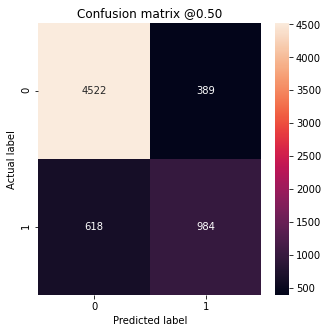

In [28]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
plotConfusion(test_labels, predictions, 0.5)

We seem to be going in the right direction.  Continue training the model

In [29]:
result = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20)

Epoch 1/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.3471 - tp: 4672.0000 - fp: 2138.0000 - tn: 22582.0000 - fn: 3169.0000 - accuracy: 0.8370 - precision: 0.6860 - recall: 0.5958 - val_loss: 0.3401 - val_tp: 474.0000 - val_fp: 101.0000 - val_tn: 3847.0000 - val_fn: 788.0000 - val_accuracy: 0.8294 - val_precision: 0.8243 - val_recall: 0.3756
Epoch 2/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.3334 - tp: 4579.0000 - fp: 1861.0000 - tn: 22859.0000 - fn: 3262.0000 - accuracy: 0.8427 - precision: 0.7110 - recall: 0.5840 - val_loss: 0.3179 - val_tp: 788.0000 - val_fp: 315.0000 - val_tn: 3633.0000 - val_fn: 474.0000 - val_accuracy: 0.8486 - val_precision: 0.7144 - val_recall: 0.6244
Epoch 3/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.3302 - tp: 4598.0000 - fp: 1864.0000 - tn: 22856.0000 - fn: 3243.0000 - accuracy: 0.8432 - precision: 0.7115 - recall: 0.5864 - val_loss: 0.3238 - val_tp: 793.0000 - val_fp: 328.0000 - v

In [30]:
plot_metrics(result)

In [31]:
predictions = model.predict(test_ds)

In [32]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
plotConfusion(test_labels, predictions, 0.5)

Legitimate Transactions Detected (True Negatives):  4649
Legitimate Transactions Incorrectly Detected (False Positives):  262
Fraudulent Transactions Missed (False Negatives):  658
Fraudulent Transactions Detected (True Positives):  944
Total Fraudulent Transactions:  1602
Precision: 0.7828
Recall: 0.5893
F1 Score Calculated: 0.6724


Our F1 Score went Up.  We are in the right direction.  We can continue to train.  Note that when we call model.fit, the model continues training where it left off. 

In [33]:
result = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20)

Epoch 1/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.3067 - tp: 4971.0000 - fp: 1756.0000 - tn: 22964.0000 - fn: 2870.0000 - accuracy: 0.8579 - precision: 0.7390 - recall: 0.6340 - val_loss: 0.2957 - val_tp: 845.0000 - val_fp: 287.0000 - val_tn: 3661.0000 - val_fn: 417.0000 - val_accuracy: 0.8649 - val_precision: 0.7465 - val_recall: 0.6696
Epoch 2/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.3097 - tp: 4951.0000 - fp: 1758.0000 - tn: 22962.0000 - fn: 2890.0000 - accuracy: 0.8573 - precision: 0.7380 - recall: 0.6314 - val_loss: 0.2901 - val_tp: 800.0000 - val_fp: 250.0000 - val_tn: 3698.0000 - val_fn: 462.0000 - val_accuracy: 0.8633 - val_precision: 0.7619 - val_recall: 0.6339
Epoch 3/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.3062 - tp: 4927.0000 - fp: 1691.0000 - tn: 23029.0000 - fn: 2914.0000 - accuracy: 0.8586 - precision: 0.7445 - recall: 0.6284 - val_loss: 0.2934 - val_tp: 767.0000 - val_fp: 258.0000 - v

In [34]:
plot_metrics(result)

In [35]:
predictions = model.predict(test_ds)

Legitimate Transactions Detected (True Negatives):  4763
Legitimate Transactions Incorrectly Detected (False Positives):  148
Fraudulent Transactions Missed (False Negatives):  786
Fraudulent Transactions Detected (True Positives):  816
Total Fraudulent Transactions:  1602
Precision: 0.8465
Recall: 0.5094
F1 Score Calculated: 0.6360


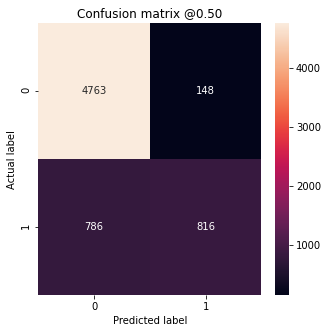

In [36]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
plotConfusion(test_labels, predictions, 0.5)

If we want to Save the entire model, including the architecture, we simply call model.save and Tensorflow will save all the architecture (the layers) and all the parameters.   You can read more about saving and restoring models in https://www.tensorflow.org/tutorials/keras/save_and_load

In [37]:
model.save('saved_model/income_model')

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


INFO:tensorflow:Assets written to: saved_model/income_model\assets


INFO:tensorflow:Assets written to: saved_model/income_model\assets


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  13824     
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dense_2 (Dense)              multiple                  8256      
_________________________________________________________________
dense_3 (Dense)              multiple                  4160      
_________________________________________________________________
dense_4 (Dense)              multiple                  2080      
_________________________________________________________________
dense_5 (Dense)              multiple                  1

We can also save only the weights.  In the figure above, we have 45,921 trainable parameters.  When we call model.save_weights, Tensorflow will save all of these.  We can later re-create the model and restore the weights.

In [39]:
model.save_weights('./checkpoints/my_checkpoint')